In [1]:
%load_ext autoreload
%autoreload 2

from typing import Any, cast, Dict

import pandas as pd
import numpy as np

from models import models, scalers
from read_data import read_datasets
from data_cleaning import prep_dataframe, DataCleaner
from training import train_test_random, split_x_y, calc_stats

2021-11-30 20:33:08.442974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 20:33:08.442998: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Generate Datasets

Copies of the dataset, each with a different scaler applies, are generated and stored for usage in training.

In [2]:
dep_var = "Log(Rmax)"
use_crossval = True

all_data = read_datasets()
combined_data = prep_dataframe(all_data, dep_var)


Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.20GHz' @ Earth Simulator, 2009
Unknown processor: 'Xeon EM64T', full name: 'Xeon EM64T  3.60GHz' @ Thunderbird, 2006


In [11]:
datasets = {}
for scaler_name, scaler in scalers.items():
    data = DataCleaner(scaler, dep_var).fit_transform(combined_data.copy())
    data = data.drop(columns="Date")

    if use_crossval:
        # We'll do splits later
        datasets[scaler_name] = data
    else:
        # Do splits for all data
        non_holdout, holdout = train_test_random(data, 0.1)
        train, test = train_test_random(non_holdout, 0.1)
        datasets[scaler_name] = split_x_y([train, test, holdout], dep_var)


Filtered duplicates to go from 10000 rows to 2476
Filtered duplicates to go from 10000 rows to 2476
Filtered duplicates to go from 10000 rows to 2476


In [12]:
from sklearn.model_selection import cross_val_score
from tqdm.notebook import tqdm

if use_crossval:
    results = pd.DataFrame(columns=["name", "scaler", "r2", "std", "min", "max"])
else:
    results = pd.DataFrame(columns=["name", "scaler", "r2", "mae", "mape", "mse"])

for model_name, model in tqdm(models.items()):
    print(model_name)
    for scaler_name in scalers.keys():
        if use_crossval:
            data = datasets[scaler_name]
            [(X, y)] = split_x_y([data], dep_var)
            scores: np.ndarray = cross_val_score(model, X, y, scoring="r2", cv=20)
            result = {
                "name": model_name,
                "scaler": scaler_name,
                "r2": scores.mean(),
                "std": scores.std(),
                "min": scores.min(),
                "max": scores.max()
            }
        else:
            train, test, holdout = datasets[scaler_name]
            model.fit(train[0], train[1])

            pred_y = model.predict(test[0])
            result = calc_stats(test[1], pred_y, print_res=False)
            result = cast(Dict[str, Any], result)
            result["name"] = model_name
            result["scaler"] = scaler_name

        results = results.append(result, ignore_index=True)


  0%|          | 0/24 [00:00<?, ?it/s]

lr_1
knn_1
knn_2
knn_3
knn_4
knn_5
knn_tuned
svr_1
svr_2
svr_tuned
rf_1
rf_2
rf_3
rf_tuned
gbt_1
gbt_2
gbt_3
gbt_4
gbt_5
mlp_1


/home/bdoney/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bdoney/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bdoney/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bdoney/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bdoney

dnn1_1
dnn2_1
xgb_1
lgbm_1


In [28]:
# Take only the maximum scaler config for each model
max_indices = results.groupby(["name"])["max"].idxmax()
maximums = results.loc[max_indices]
maximums.sort_values(by="max", ascending=False)


,name,scaler,r2,std,min,max
55,gbt_5,Standard,-2.542943e+00,5.783438e+00,-1.765794e+01,0.976136
67,xgb_1,Standard,-2.459717e+00,6.099258e+00,-2.141294e+01,0.972777
60,dnn1_1,Robust,-2.029214e+00,4.753331e+00,-1.430351e+01,0.969244
51,gbt_4,Robust,-2.946192e+00,6.366976e+00,-1.951379e+01,0.969150
63,dnn2_1,Robust,-3.213283e+00,5.813637e+00,-1.806931e+01,0.968640
49,gbt_3,Standard,-3.325399e+00,6.700777e+00,-2.116742e+01,0.967952
69,lgbm_1,Robust,-2.549545e+00,5.812606e+00,-1.799272e+01,0.967713
40,rf_tuned,Standard,-3.056406e+00,6.986834e+00,-2.478243e+01,0.962250
34,rf_2,Standard,-3.028685e+00,6.903588e+00,-2.441303e+01,0.961971
31,rf_1,Standard,-3.152673e+00,7.143256e+00,-2.521011e+01,0.961477


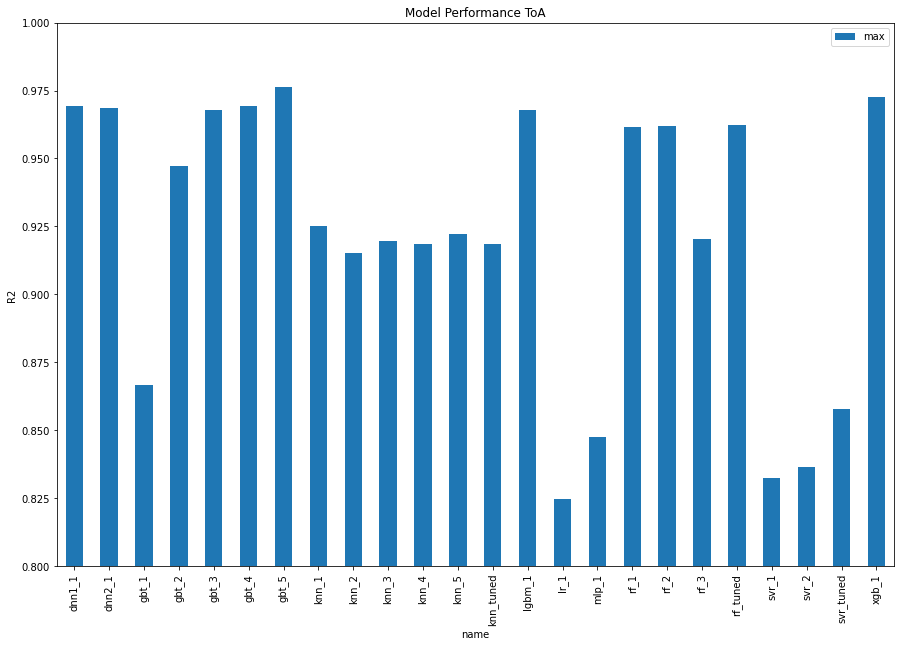

In [41]:
axis = maximums.plot.bar(x="name", y="max", figsize=(
    15, 10), ylabel="R2", ylim=(0.8, 1), title="Model Performance ToA")


In [42]:
from datetime import datetime
import pathlib

now = datetime.now()
dt_string = now.strftime(r"%m-%d-%YT%I-%M-%S%p")

all_identifier = f"all_results_toa_{dt_string}"
best_identifier = f"best_results_toa_{dt_string}"
out_dir = pathlib.Path("out")
all_csv_path = out_dir / (all_identifier + ".csv")
best_csv_path = out_dir / (best_identifier + ".csv")
img_path = out_dir / (best_identifier + ".png")

results.to_csv(all_csv_path)
maximums.to_csv(best_csv_path)
axis.figure.set_facecolor((1, 1, 1, 1))
axis.figure.savefig(img_path)
